In [3]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from scipy.stats import norm
from scipy.stats import median_abs_deviation
from scipy.optimize import curve_fit

from astropy.io import fits
import astropy.units as u
from astropy.visualization import quantity_support
from astropy.cosmology import Planck18_arXiv_v2

from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn import mixture
from sklearn.neighbors import KernelDensity

from astroML.linear_model import PolynomialRegression

import pandas as pd

import glob

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "cm",
      "font.size" : "14",
      "figure.figsize" : [10,5]}
plt.rcParams.update(rc)

%config InlineBackend.figure_format='retina'

In [4]:
#reading file

mwsc = 'browse_results.fits'

file = fits.open(mwsc)
data_mwsc = file[1].data
header_mwsc = file[1].header
file.close()

In [5]:
header_mwsc


XTENSION= 'TABLE   '           / ASCII table extension                          
BITPIX  =                    8 / Mandatory value                                
NAXIS   =                    2 / Mandatory value                                
NAXIS1  =                   84 / Length of row                                  
NAXIS2  =                 1000 / Number of rows                                 
PCOUNT  =                    0 / Mandatory value                                
GCOUNT  =                    1 / Mandatory value                                
TFIELDS =                    9 / Number of fields                               
                                                                                
EXTNAME = 'MWSC'               / Extension name                                 
TABLE   = 'heasarc_mwsc'       / Table designation                              
TAB_DESC= 'Milky Way Star Clusters Catalog'                                     
TAB_URL = 'https://heasarc.g

In [6]:
mask = (data_mwsc.field('DEC')>35) & (data_mwsc.field('DEC')<60) & (data_mwsc.field('RA')>15) & (data_mwsc.field('RA')<41) & (data_mwsc.field('CLUSTER_RADIUS')<0.22) & (data_mwsc.field('CLUSTER_RADIUS')>0.1) & (data_mwsc.field('LOG_AGE')<7.5)  

new_data_mwsc = data_mwsc[mask]

In [7]:
print(new_data_mwsc.field('NAME').shape)
print(new_data_mwsc)

(2,)
[('ASCC 7', 29.775, 58.925, 0.18, -49.0, 10.0, 2000.0, 7.4, 0.0)
 ('FSR 0614', 40.62, 56.735, 0.13, 0.0, 0.0, 2787.0, 6.75, 0.0)]


In [8]:
print(new_data_mwsc.field('NAME').shape)
print(new_data_mwsc)

(2,)
[('ASCC 7', 29.775, 58.925, 0.18, -49.0, 10.0, 2000.0, 7.4, 0.0)
 ('FSR 0614', 40.62, 56.735, 0.13, 0.0, 0.0, 2787.0, 6.75, 0.0)]


# NGC956

In [9]:
#NGC catalogue

NGC = 'NGC_catalog.fits'

file = fits.open(NGC)
data_NGC = file[1].data
header_NGC = file[1].header
file.close()

In [10]:
header_NGC

XTENSION= 'TABLE   '           / Ascii Table Extension                          
BITPIX  =                    8 / Character data                                 
NAXIS   =                    2 / Simple 2-D matrix                              
NAXIS1  =                  224 / Number of bytes per record                     
NAXIS2  =                 4669 / Number of records                              
PCOUNT  =                    0 / Get rid of random parameters                   
GCOUNT  =                    1 / Only one group (isn't it obvious?)             
TFIELDS =                   27 / Number of data fields (columns)                
EQUINOX =               2000.0 / Equinox of coordinates (J system)              
EPOCH   =               2000.0 / Epoch of coordinates                           
EXTNAME = 'stars_q2/*'         / *Star catalogs for 650 sky areas               
COMMENT  Note on stars_q2/*: The file names include the MWSC sequential number  
         and a name of a clu

In [11]:
data_NGC.field('Vmag    ')

array([  9.357,   9.75 ,   8.253, ..., -99.99 , -99.99 , -99.99 ])

In [12]:
mask_V = data_NGC.field('Vmag    ')>-99.99

new_NGC_data = data_NGC[mask_V]
V_ordered = np.sort(new_NGC_data.field('Vmag    '))
print(V_ordered)
print(np.mean(V_ordered))

[ 8.253  8.424  8.684 ... 19.2   19.3   19.3  ]
16.188251924063625


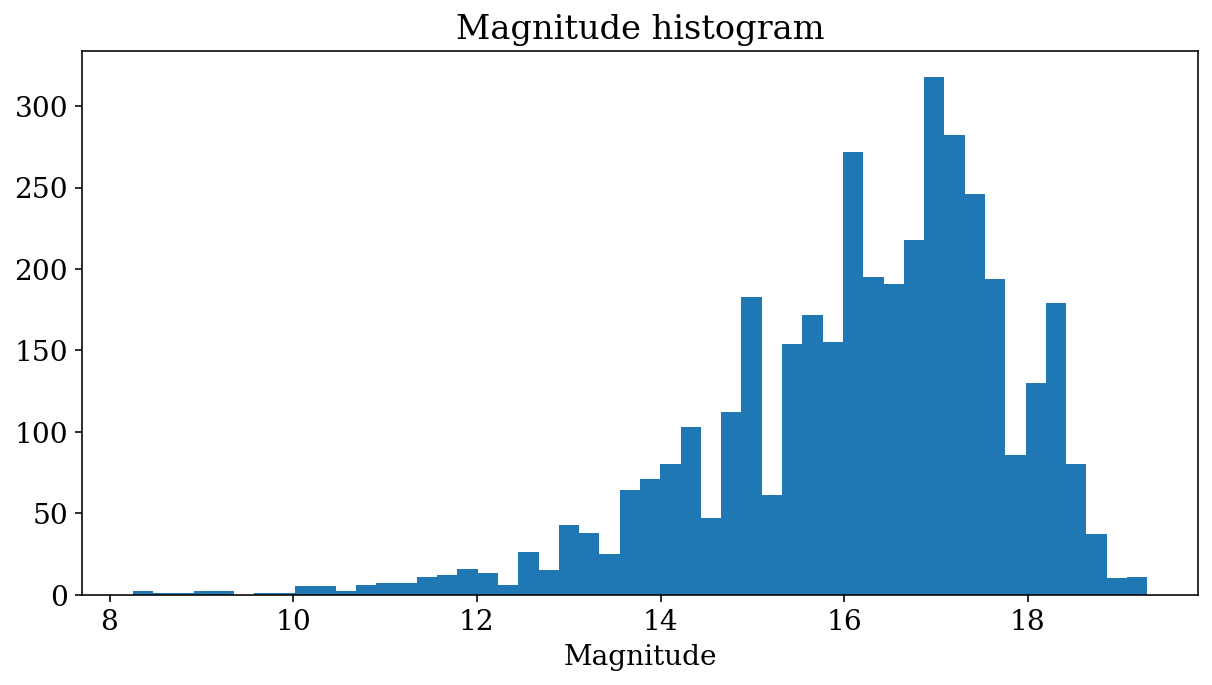

In [13]:
plt.hist(new_NGC_data.field('Vmag    '), bins=50)
plt.title('Magnitude histogram')
plt.xlabel('Magnitude')
plt.show()

Compute the ADU/s rate

In [14]:
#functions

In [15]:
def flux_nu(m): 
    return 10**(-m/2.5) * 3631 #Jy
    

def flux_lambda (m):
    return flux_nu(m) / (3.34*10**4) / (5008)**2

def electron_rate_ADU(m):
    C_Ha = 15.39
    C_OII = 15.28
    C_SII = 15.47
    
    return flux_lambda(m) * 10**C_Ha  / (0.6)

In [16]:
m_max = 8.253
m_avg = 16.2

## Compute SNR

### Max brightness

In [17]:
S = electron_rate_ADU(m_max)
print(S)

8863.390655116204


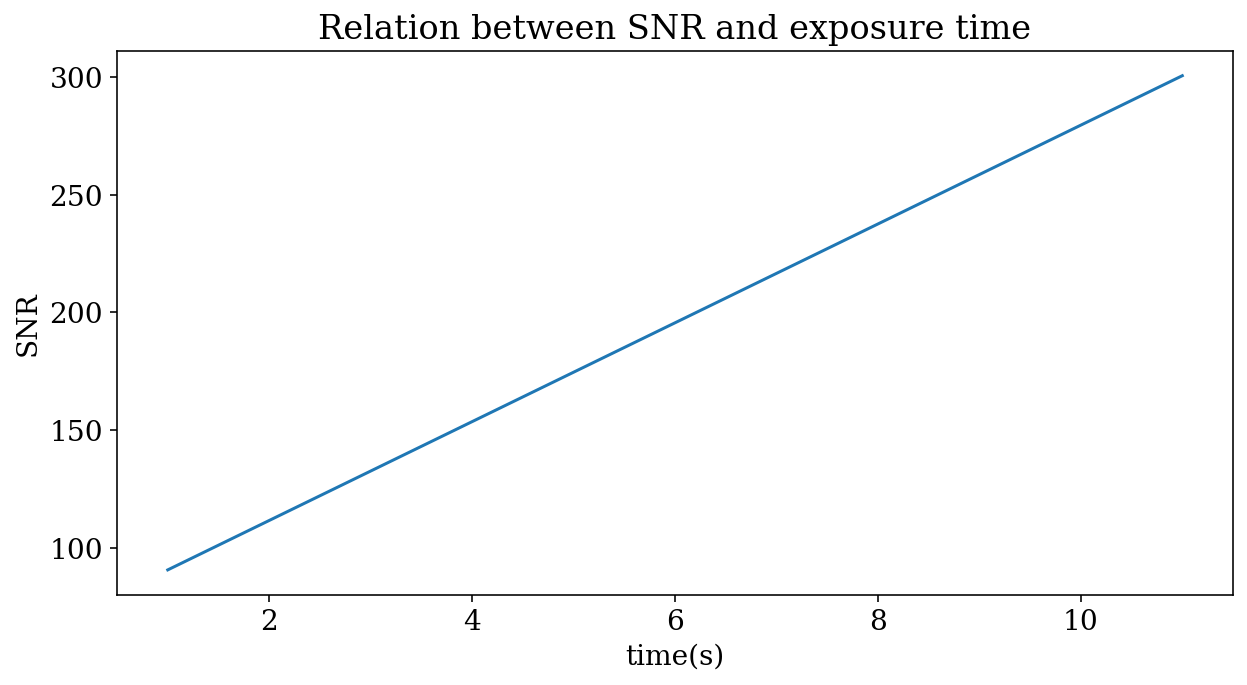

In [18]:
t=np.arange(1, 15, 10)
n = 2.333 * 10**3   # number of pixels covered by our source 
S_B = 0.1            # sky brightness
C_D = 0.2

SNR = S*t / np.sqrt(S*t + n*t*(S_B + C_D))

plt.xlabel('time(s)')
plt.ylabel('SNR')
plt.title('Relation between SNR and exposure time')
plt.plot(t, SNR)


### Average magnitude

In [19]:
S = electron_rate_ADU(m_avg)
print(S)

5.872187190132193


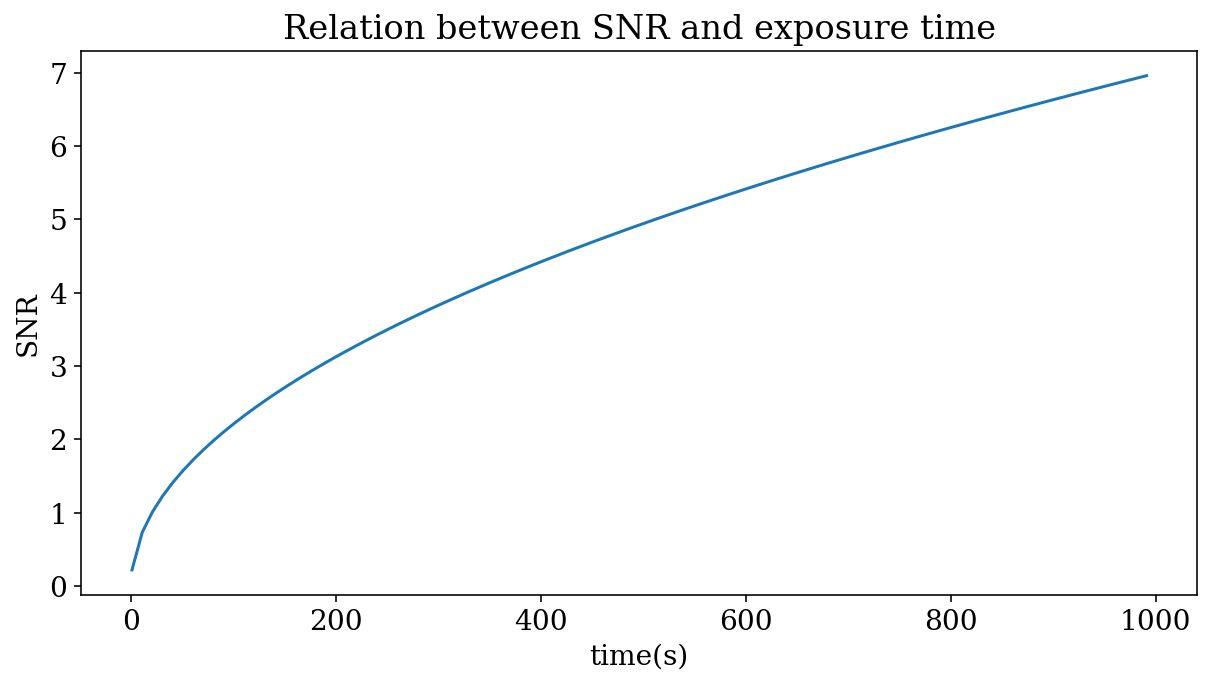

In [20]:
t=np.arange(1, 1000, 10)
n = 2.333 * 10**3   # number of pixels covered by our source 
S_B = 0.1            # sky brightness
C_D = 0.2

SNR = S*t / np.sqrt(S*t + n*t*(S_B + C_D))

plt.xlabel('time(s)')
plt.ylabel('SNR')
plt.title('Relation between SNR and exposure time')
plt.plot(t, SNR)

# FSR0614

In [21]:
#FSR catalogue

FSR = 'FSR_catalog.fits'

file = fits.open(FSR)
data_FSR = file[1].data
header_FSR = file[1].header
file.close()

In [22]:
header_FSR

XTENSION= 'TABLE   '           / Ascii Table Extension                          
BITPIX  =                    8 / Character data                                 
NAXIS   =                    2 / Simple 2-D matrix                              
NAXIS1  =                  224 / Number of bytes per record                     
NAXIS2  =                10348 / Number of records                              
PCOUNT  =                    0 / Get rid of random parameters                   
GCOUNT  =                    1 / Only one group (isn't it obvious?)             
TFIELDS =                   27 / Number of data fields (columns)                
EQUINOX =               2000.0 / Equinox of coordinates (J system)              
EPOCH   =               2000.0 / Epoch of coordinates                           
EXTNAME = 'stars_q2/*'         / *Star catalogs for 650 sky areas               
COMMENT  Note on stars_q2/*: The file names include the MWSC sequential number  
         and a name of a clu

In [23]:
mask_V = data_FSR.field('Vmag    ')>-99.99

new_FSR_data = data_FSR[mask_V]
V_ordered = np.sort(new_FSR_data.field('Vmag    '))
print(V_ordered)
print(np.mean(V_ordered))

[ 8.27   8.54   8.623 ... 18.8   18.9   19.   ]
16.741416728902163


In [24]:
m_max = 8.27
m_avg = 16.7

## Compute SNR

### Brightest star

In [25]:
S = electron_rate_ADU(m_max)
print(S)


8725.692243998608


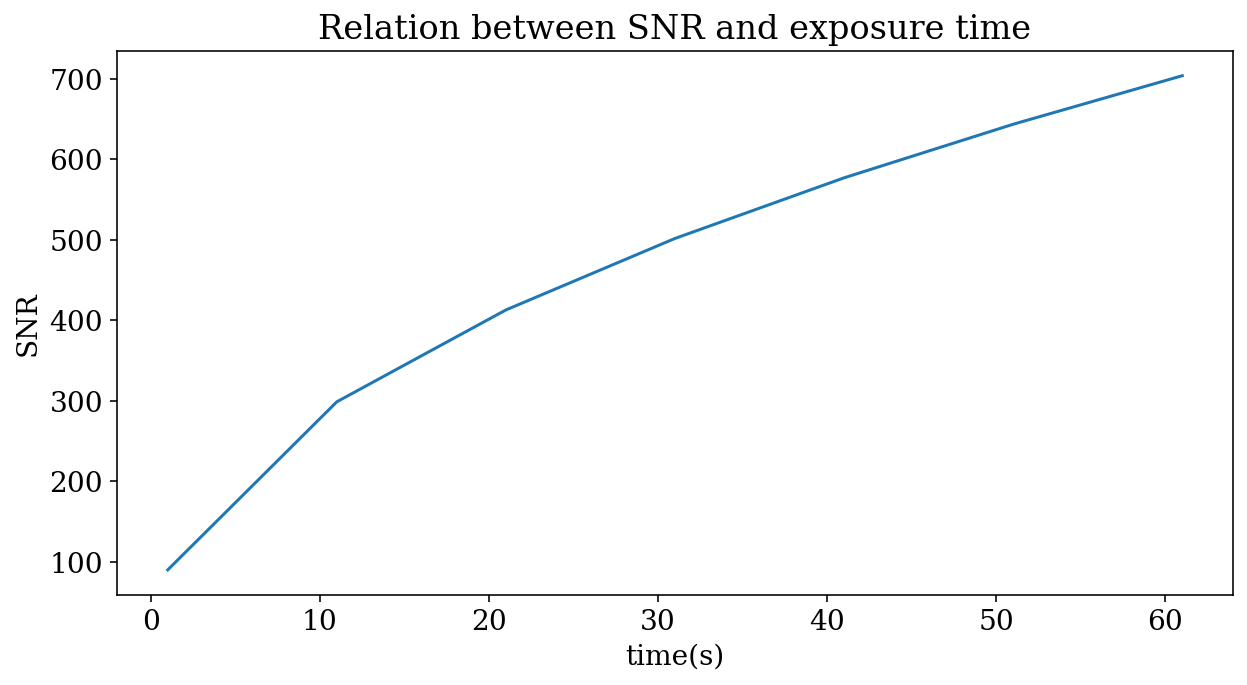

In [26]:
t=np.arange(1, 70, 10)
n = 2.166 * 10**3
S_B = 0.1
C_D = 0.2

SNR = S*t / np.sqrt(S*t + n*t*(S_B + C_D))

plt.xlabel('time(s)')
plt.ylabel('SNR')
plt.title('Relation between SNR and exposure time')
plt.plot(t, SNR)

### Average magnitude

In [27]:
S = electron_rate_ADU(m_avg)
print(S)

3.7050996357764143


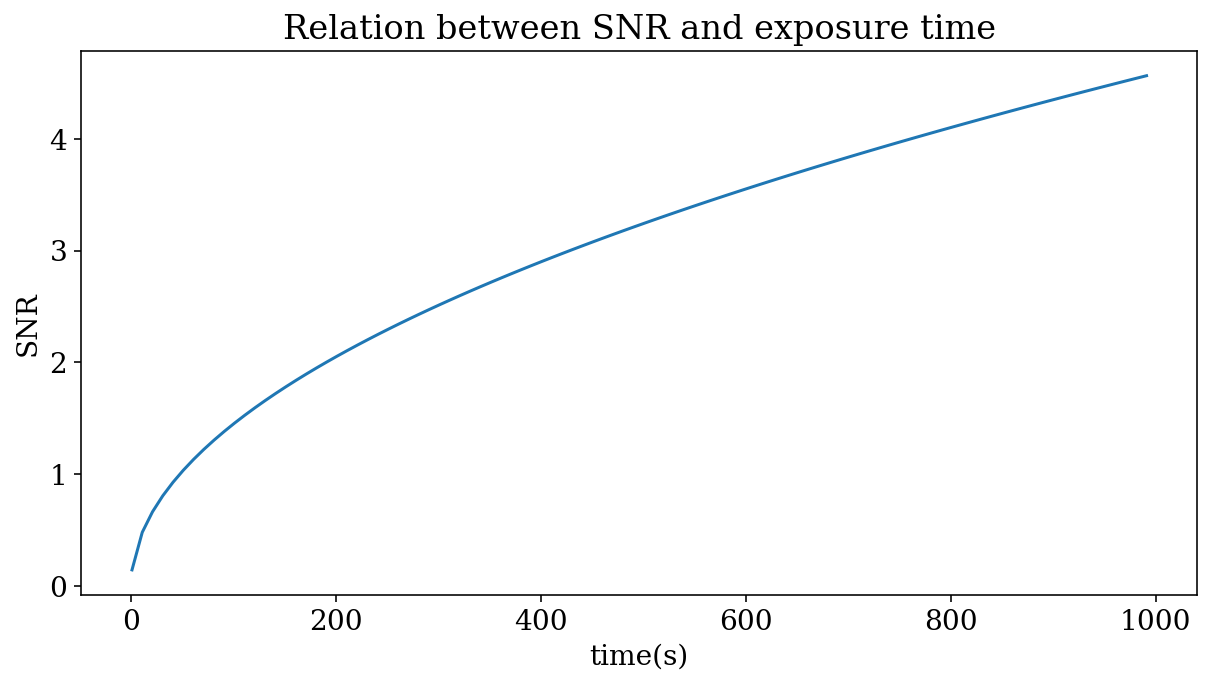

In [28]:
t=np.arange(1, 1000, 10)
n = 2.166 * 10**3
S_B = 0.1
C_D = 0.2

SNR = S*t / np.sqrt(S*t + n*t*(S_B + C_D))

plt.xlabel('time(s)')
plt.ylabel('SNR')
plt.title('Relation between SNR and exposure time')
plt.plot(t, SNR)

# Data analysis

In [119]:
#function to open files

def read_files(file_names):
    data = []
    
    for file in file_names:
        myfile = fits.open(file)
        data.append(myfile[0].data)
        myfile.close()
        
    return data

##   Bias frame


In [120]:
# read the files

bias_names = glob.glob('../work/20221018/calib_0*bias*')

bias1 = fits.open(bias_names[0])
data1 = bias1[0].data
header1 = bias1[0].header
bias1.close()

print(bias1.info())
print(header1)

Filename: ../work/20221018\calib_033bias.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      25   (4499, 3599)   uint16   
None
SIMPLE  =                    T                                                  BITPIX  =                   16                                                  NAXIS   =                    2                                                  NAXIS1  =                 4499                                                  NAXIS2  =                 3599                                                  BZERO   =           32768.000000                                                BSCALE  =             1.000000                                                  DATAMIN =             0.000000                                                  DATAMAX =           65535.000000                                                INSTRUME=           'ATIK-16200: fw rev 3.52'                                   FILTER  =           '

Shape of stack (15, 3599, 4499)
Shape of array (3599, 4499)


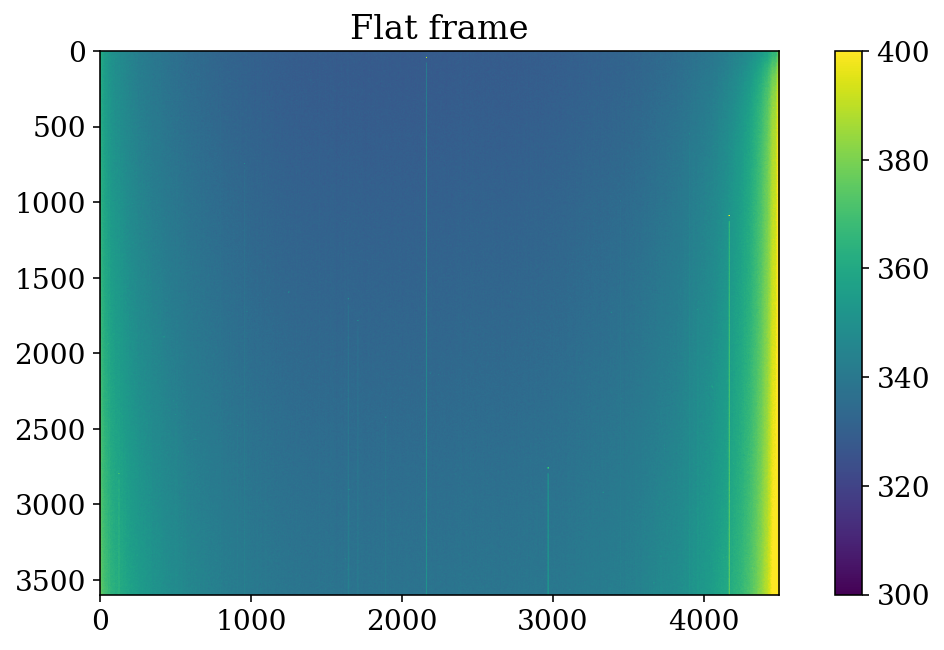

In [155]:
all_bias = read_files(bias_names)

all_bias = np.array(all_bias)
print('Shape of stack', all_bias.shape)

meanbias = np.mean(all_bias, axis=0)
print('Shape of array', meanbias.shape)

plt.clf()
plt.imshow(meanbias, clim=[300,400])
plt.title('Flat frame')
plt.colorbar()

## Flat frame

In [127]:
# H_alpha
flat_Halpha_names = glob.glob('../work/20221018/flat_*Halpha*')
all_flatHa = read_files(flat_Halpha_names)
all_flatHa = np.array(all_flatHa)
print('Stack shape: ', all_flatHa.shape)

mean_flatHa = np.mean(all_flatHa, axis=0)
print('Mean shape: ', mean_flatHa.shape)

#OIII
flat_OIII_names = glob.glob('../work/20221018/flat_*OIII*')
all_flatOIII = read_files(flat_OIII_names)
all_flatOIII = np.array(all_flatOIII)
print('Stack shape: ', all_flatOIII.shape)

mean_flatOIII = np.mean(all_flatOIII, axis=0)
print('Mean shape: ', mean_flatOIII.shape)

#SII
flat_SII_names = glob.glob('../work/20221018/flat_*SII*')
all_flatSII = read_files(flat_SII_names)
all_flatSII = np.array(all_flatSII)
print('Stack shape: ', all_flatSII.shape)

mean_flatSII = np.mean(all_flatSII, axis=0)
print('Mean shape: ', mean_flatSII.shape)


Stack shape:  (5, 3599, 4499)
Mean shape:  (3599, 4499)
Stack shape:  (5, 3599, 4499)
Mean shape:  (3599, 4499)
Stack shape:  (5, 3599, 4499)
Mean shape:  (3599, 4499)


min: 13794.2
max: 50951.8


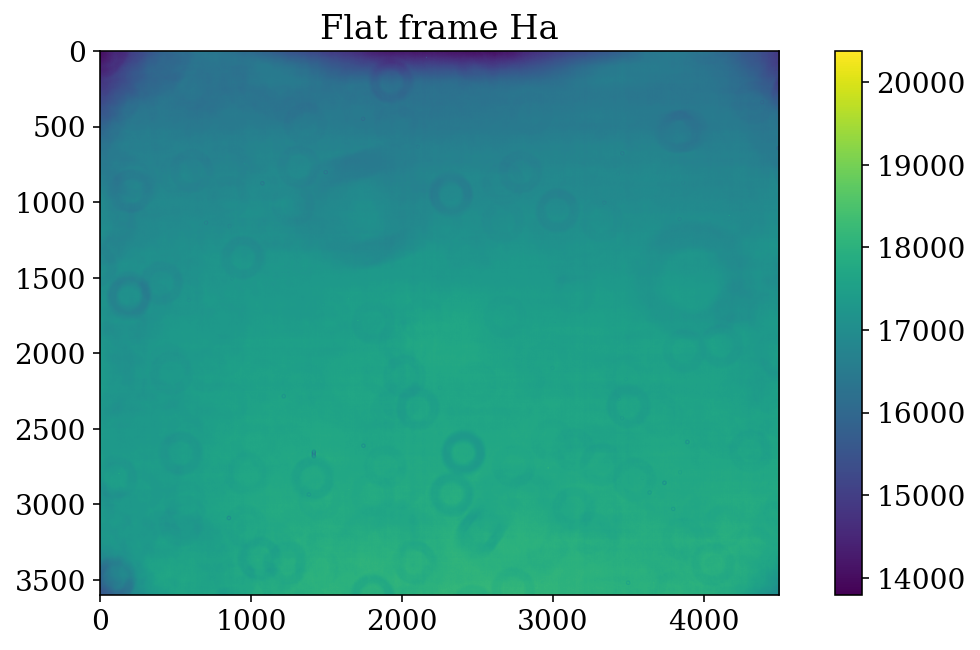

In [154]:
# Halpha plot:

print('min:', np.min(mean_flatHa))
print('max:', np.max(mean_flatHa) )

plt.clf()
plt.title('Flat frame Ha')
plt.imshow(mean_flatHa, clim=[np.min(mean_flatHa), np.max(mean_flatHa)/2.5])
plt.colorbar()

min: 10352.4
max: 49740.0


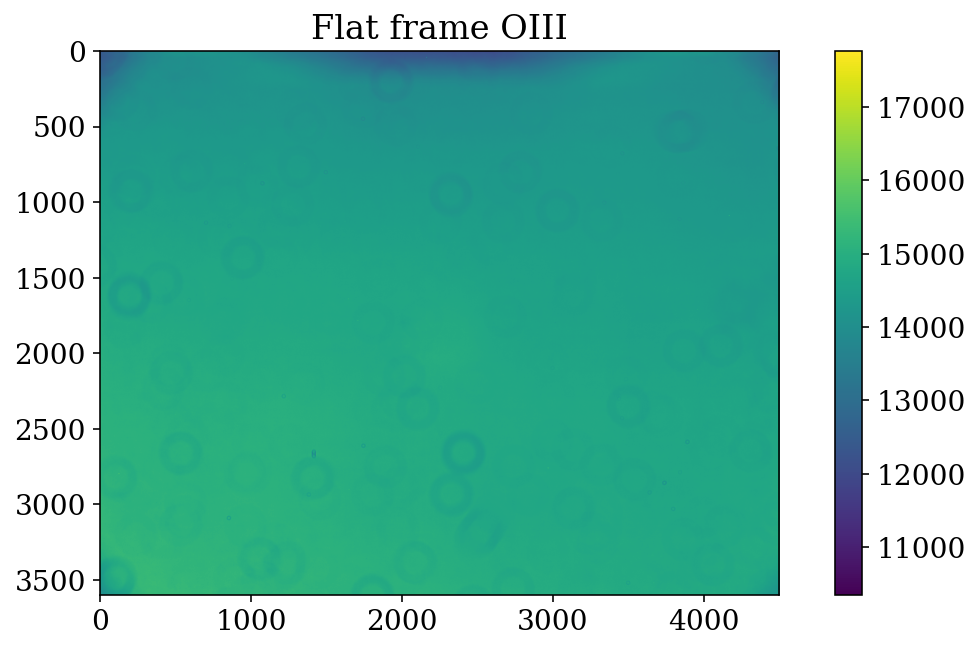

In [170]:
# OIII plot:

print('min:', np.min(mean_flatOIII))
print('max:', np.max(mean_flatOIII) )

plt.clf()
plt.title('Flat frame OIII')
plt.imshow(mean_flatOIII, clim=[np.min(mean_flatOIII), np.max(mean_flatOIII)/2.8])
plt.colorbar()

min: 12825.8
max: 50324.4


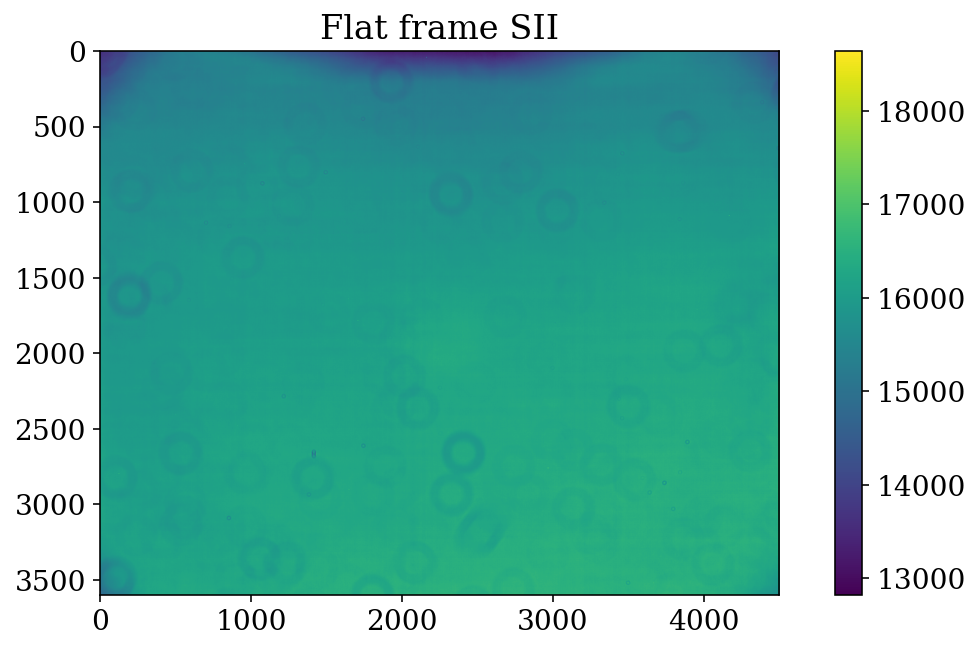

In [172]:
# SII plot:

print('min:', np.min(mean_flatSII))
print('max:', np.max(mean_flatSII) )

plt.clf()
plt.title('Flat frame SII')
plt.imshow(mean_flatSII, clim=[np.min(mean_flatSII), np.max(mean_flatSII)/2.7])
plt.colorbar()